In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("Customer Churn.csv")

# Quick check: First 5 rows
print(df.head())

# DataFrame info: columns, types, missing values, etc.
print(df.info())

# Basic descriptive statistics for numeric columns
print(df.describe())


   Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   25   
2                       24          3    

### **1. CLUSTERING : K-MEANS**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Suppose 'df' is our DataFrame with only feature columns
X = df.drop("Churn", axis=1)  # if Churn exists, remove it because we want unsupervised

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
df["Cluster"] = kmeans.labels_
print(df.head())


   Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   25   
2                       24          3    

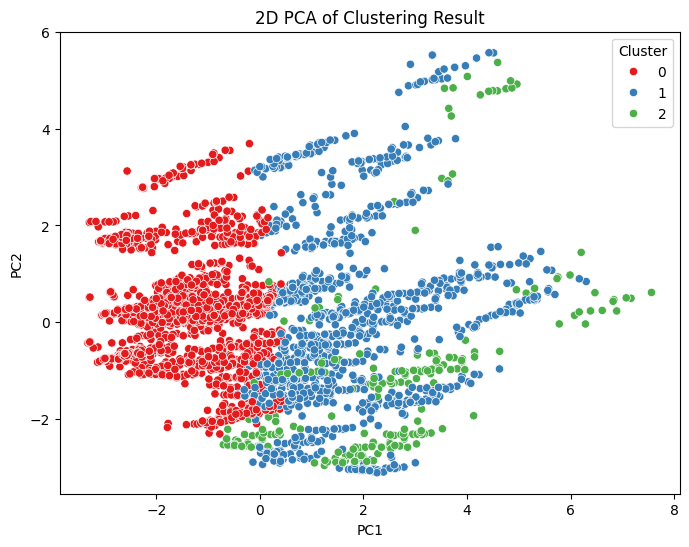

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Suppose you already have:
# X_scaled -> your scaled dataset used for clustering
# cluster_labels -> kmeans.labels_ (or any cluster assignment array)

# 1) Reduce data to 2D via PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)  # shape: (n_samples, 2)

# 2) Convert to a DataFrame for convenience
import pandas as pd
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Cluster"] = cluster_labels  # from KMeans or other

# 3) Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="Set1")
plt.title("2D PCA of Clustering Result")
plt.legend(title="Cluster", loc="best")
plt.show()


### **2. ANOMALY DETECTION : LOF**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# 1) Load or prepare your DataFrame (df) with numeric features
# If you have a 'Churn' label (or other labels), we typically drop them for unsupervised outlier detection
X = df.drop("Churn", axis=1, errors="ignore")

# 2) Optional: encode categorical columns, if any
# X = pd.get_dummies(X, drop_first=True)

# 3) Optional: scale the features (often helps with distance-based methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Local Outlier Factor setup
# n_neighbors: how many neighbors LOF uses to compute local density
# contamination: expected fraction of outliers
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)

# LOF is usually fit_predict on the same dataset (it doesn't do partial_fit)
outlier_labels = lof.fit_predict(X_scaled)
# outlier_labels = -1 (outlier) or 1 (inlier)

# 5) Because LOF doesn't store the model for new data easily, we use 'negative_outlier_factor_'
# to get the raw LOF scores. Lower (more negative) = more likely an outlier
lof_scores = lof.negative_outlier_factor_

# 6) Attach results to the DataFrame
df["LOF_Label"] = outlier_labels               # 1 or -1
df["LOF_Score"] = lof_scores                  # More negative = more outlier

# 7) Quick view of results
print(df.head())

# 8) Example: count how many outliers
num_outliers = (df["LOF_Label"] == -1).sum()
num_inliers = (df["LOF_Label"] == 1).sum()
print(f"Outliers: {num_outliers}, Inliers: {num_inliers}")


   Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   25   
2                       24          3    

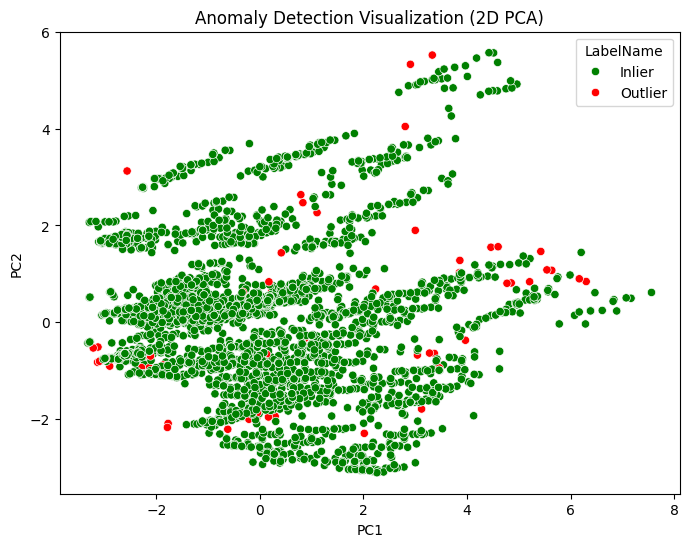

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Suppose X_scaled is your scaled dataset,
# outlier_labels is from LOF or IsolationForest (1 = inlier, -1 = outlier)

# 1) PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 2) Make a DataFrame
df_anomaly = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_anomaly["AnomalyLabel"] = outlier_labels

# Map -1 -> "Outlier", 1 -> "Inlier" if you want more readable labels
df_anomaly["LabelName"] = df_anomaly["AnomalyLabel"].map({1: "Inlier", -1: "Outlier"})

# 3) Plot with seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_anomaly, x="PC1", y="PC2", hue="LabelName", palette=["green","red"])
plt.title("Anomaly Detection Visualization (2D PCA)")
plt.show()


### **3. CLASSIFICATION : DECISION TREE**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv("Customer Churn.csv")

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Create and train a decision tree
dtree = DecisionTreeClassifier(max_depth=5, random_state=42)
dtree.fit(X_train, y_train)

# Predict
y_pred = dtree.predict(X_test)

# Evaluate
print("Confusion Matrix (Decision Tree):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred))


Confusion Matrix (Decision Tree):
[[512  19]
 [ 35  64]]

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       531
           1       0.77      0.65      0.70        99

    accuracy                           0.91       630
   macro avg       0.85      0.81      0.83       630
weighted avg       0.91      0.91      0.91       630



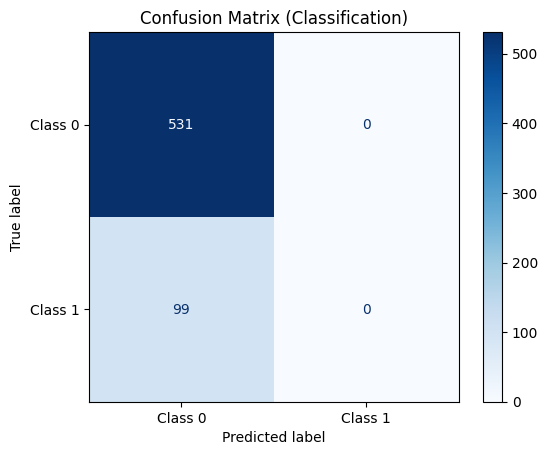

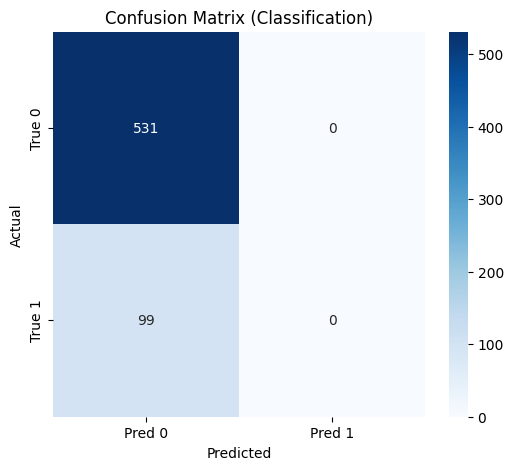

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppose y_test and y_pred are your true and predicted labels from the classification step

# Option A: Using sklearn >= 1.0 has ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0","Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Classification)")
plt.show()

# Option B: Using seaborn heatmap (if sklearn version is older)
import numpy as np

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix (Classification)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
